In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

# EVT 

In [3]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [4]:
def bg_cum_dist(z: np.ndarray, z_star: float, beta: float, gamma: float) -> np.ndarray:
    return np.exp(-(gamma/beta*(z-z_star))**(-1/gamma))

def bg_pdf_dist(z: np.ndarray, z_star: float, beta: float, gamma: float):
    return 1/beta * (gamma/beta*(z-z_star))**(-1/gamma -1) * np.exp(-(gamma/beta*(z-z_star))**(-1/gamma))

def bg_log_likelihood(z: np.ndarray, z_star: float, beta: float, gamma: float):
    return -np.sum(np.log(beta) + (1/gamma + 1 ) * np.log(gamma/beta*(z-z_star)) - (gamma/beta*(z-z_star))**(-1/gamma))

def bg_ll_jac(z: np.ndarray, z_star: float, beta: float, gamma: float):
    jac = np.zeros([2])
    # dll/beta
    jac[0] = -np.sum(1/beta - (1/gamma +1) / (gamma/beta*(z-z_star)) * gamma/beta -(gamma/beta*(z-z_star))**(-1/gamma -1))
    jac[1] = -np.sum()
    return jac

#\log\left(\mathcal{L}\left(z; z^{*}, \beta, \gamma\right)\right) & = & - n \log \beta - \left(1+\frac{1}{\gamma}\right)\sum_{i=1}^{n} \log\left(2+\frac{\gamma}{\beta}\left(z_i - z^{*}\right)\right) \\ &&- \sum_{i=1}^{n}\left(2+ \frac{\gamma}{\beta}\left(z_i - z^{*}\right)\right)^{-\frac{1}{\gamma}}.

In [5]:
pdfs = bg_pdf_dist(np.array([1,2,3]), 4, 1, -0.5)
pdfs

array([0.15809884, 0.36787944, 0.38940039])

In [8]:
np.log(pdfs), np.sum(np.log(pdfs)), bg_log_likelihood(np.array([1, 2, 3]), 4, 1, -0.5)

(array([-1.84453489, -1.        , -0.94314718]),
 -3.787682072451781,
 3.212317927548219)

In [14]:
import numpy as np

@np.vectorize
def ll_gamma(gamma: float = -0.5) -> float:
    return np.sum(np.log(bg_pdf_dist(np.array([1, 2, 3]), 4, 1, gamma)))


@np.vectorize
def ll_beta(beta: float = 1) -> float:
    return np.sum(np.log(bg_pdf_dist(np.array([1, 2, 3]), 4, beta, -0.5)))

@np.vectorize
def ll_beta_gamma(beta: float = 1, gamma: float = -0.5) -> float:
    return np.sum(np.log(bg_pdf_dist(np.array([1, 2, 3]), 4, beta, gamma)))


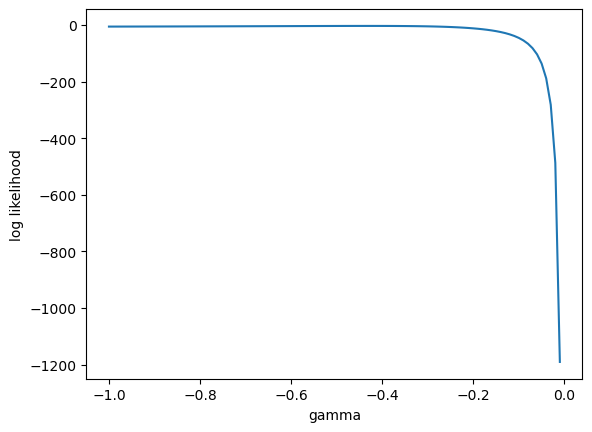

In [10]:
gammas = np.linspace(-1, -0.01, 100)
lls = ll_gamma(gammas)

plt.plot(gammas, lls)
plt.xlabel('gamma')
plt.ylabel('log likelihood')
plt.show()

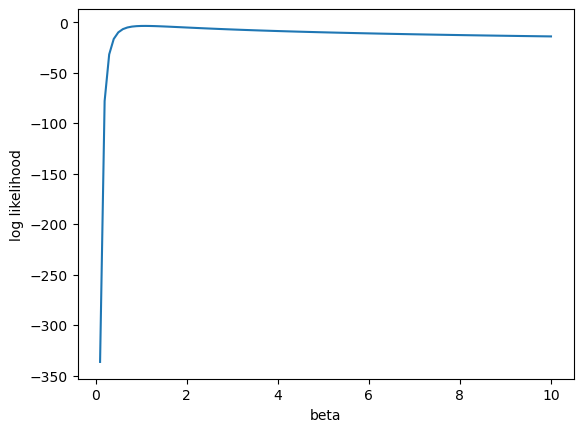

In [12]:
betas = np.linspace(0.1, 10, 100)
lls = ll_beta(betas)
plt.plot(betas, lls)
plt.xlabel("beta")
plt.ylabel("log likelihood")
plt.show()

/tmp/ipykernel_180803/1464497232.py:14: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(bg_pdf_dist(np.array([1, 2, 3]), 4, beta, gamma)))


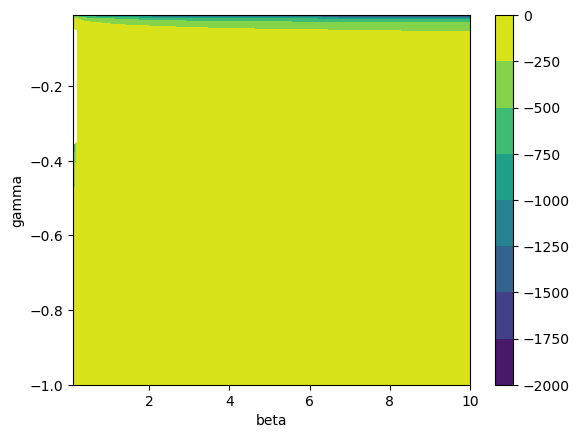

In [16]:
betas = np.linspace(0.1, 10, 100)
gammas = np.linspace(-1, -0.01, 100)
betas, gammas = np.meshgrid(betas, gammas)

lls = ll_beta_gamma(betas, gammas)

plt.contourf(betas, gammas, lls)
plt.xlabel("beta")
plt.ylabel("gamma")
plt.colorbar()

In [63]:
z = np.array([1, 2, 3, 4, 5])
z_star = 6

In [17]:
from scipy.optimize import minimize

In [19]:
mins = minimize(
    lambda x: -ll_beta_gamma(x[0], x[1]),
    x0=[1, -0.5],
    bounds=[(0.01, None), (None, -0.01)],
)


Text(0.5, 0, 'Return Period [years]')

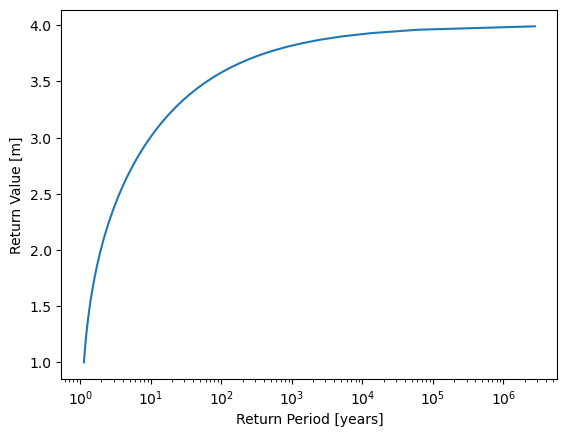

In [22]:
znew = np.linspace(1, 3.99, num=100)
rp = 1 / (1 - bg_cum_dist(znew, 4, mins.x[0], mins.x[1]))
plt.semilogx(rp, znew)
plt.ylabel("Return Value [m]")
plt.xlabel("Return Period [years]")

In [20]:
mins

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 3.556251540112104
        x: [ 8.247e-01 -3.652e-01]
      nit: 9
      jac: [-8.882e-08 -1.776e-07]
     nfev: 36
     njev: 12
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [64]:
from scipy.optimize import minimize

mins = minimize(lambda x: -bg_log_likelihood(z, z_star, x[0], x[1]), 
         x0=[np.std(z),-0.1], bounds=[(0.01, None), (None, -0.01)])

In [65]:
mins.x

array([ 0.01, -0.01])

In [72]:
znew = np.linspace(4, 5.99, num=100)

rp = 1 / (1 - bg_cum_dist(znew, z_star, mins.x[0], mins.x[1]))

/tmp/ipykernel_195576/3595758468.py:3: RuntimeWarning: divide by zero encountered in divide
  rp = 1 / (1 - bg_cum_dist(znew, z_star, mins.x[0], mins.x[1]))


In [73]:
import matplotlib.pyplot as plt
from sithom.plot import plot_defaults
plot_defaults()

Text(0.5, 0, 'Return Period [years]')

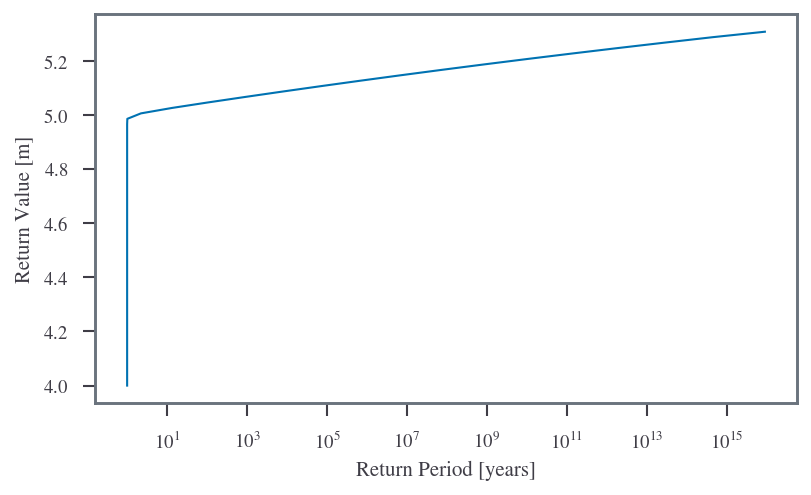

In [74]:
plt.semilogx(rp, znew)
plt.ylabel("Return Value [m]")
plt.xlabel("Return Period [years]")
# plot a horizontal line at z_star
